In [ ]:
!pip install transformers datasets py_vncorenlp emoji torchinfo

In [2]:
import transformers 
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datasets import load_dataset, DatasetDict

In [3]:
raw_ds = load_dataset("qanastek/MASSIVE", "vi-VN")
raw_ds

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset massive downloaded and prepared to /root/.cache/huggingface/datasets/qanastek___massive/vi-VN/1.0.0/31cdffab94ac97bfe5a394b1e96344c96f0ad847e1d796c7562d8c8b449e22e6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'tokens', 'ner_tags', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'tokens', 'ner_tags', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'tokens', 'ner_tags', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2974
    })
})

In [4]:
raw_ds['train'][1]


{'id': '2',
 'locale': 'vi-VN',
 'partition': 'train',
 'scenario': 9,
 'intent': 55,
 'utt': 'cài báo thức trong hai giờ kể từ bây giờ',
 'annot_utt': 'cài báo thức trong [time : hai giờ kể từ bây giờ]',
 'tokens': ['cài',
  'báo',
  'thức',
  'trong',
  'hai',
  'giờ',
  'kể',
  'từ',
  'bây',
  'giờ'],
 'ner_tags': [0, 0, 0, 0, 60, 16, 16, 16, 16, 16],
 'worker_id': '3',
 'slot_method': {'slot': ['time'], 'method': ['translation']},
 'judgments': {'worker_id': ['36', '37', '3'],
  'intent_score': [1, 1, 1],
  'slots_score': [1, 1, 1],
  'grammar_score': [4, 4, 4],
  'spelling_score': [2, 2, 2],
  'language_identification': ['target', 'target', 'target']}}

In [5]:
name_intents = raw_ds['train'].features['intent'].names
print(name_intents)

['audio_volume_other', 'play_music', 'iot_hue_lighton', 'general_greet', 'calendar_set', 'audio_volume_down', 'social_query', 'audio_volume_mute', 'iot_wemo_on', 'iot_hue_lightup', 'audio_volume_up', 'iot_coffee', 'takeaway_query', 'qa_maths', 'play_game', 'cooking_query', 'iot_hue_lightdim', 'iot_wemo_off', 'music_settings', 'weather_query', 'news_query', 'alarm_remove', 'social_post', 'recommendation_events', 'transport_taxi', 'takeaway_order', 'music_query', 'calendar_query', 'lists_query', 'qa_currency', 'recommendation_movies', 'general_joke', 'recommendation_locations', 'email_querycontact', 'lists_remove', 'play_audiobook', 'email_addcontact', 'lists_createoradd', 'play_radio', 'qa_stock', 'alarm_query', 'email_sendemail', 'general_quirky', 'music_likeness', 'cooking_recipe', 'email_query', 'datetime_query', 'transport_traffic', 'play_podcasts', 'iot_hue_lightchange', 'calendar_remove', 'transport_query', 'transport_ticket', 'qa_factoid', 'iot_cleaning', 'alarm_set', 'datetime_c

In [32]:
from collections import Counter
my_counter = Counter(list(map(lambda x: name_intents[x],raw_ds['train']['intent'])))
counts = my_counter.most_common()
df_ = pd.DataFrame(counts, columns=['value', 'count'])
df_ = df_.sort_values('count', ascending=False)
df_.head()

,value,count
0,calendar_set,810
1,play_music,639
2,weather_query,573
3,calendar_query,566
4,general_quirky,555


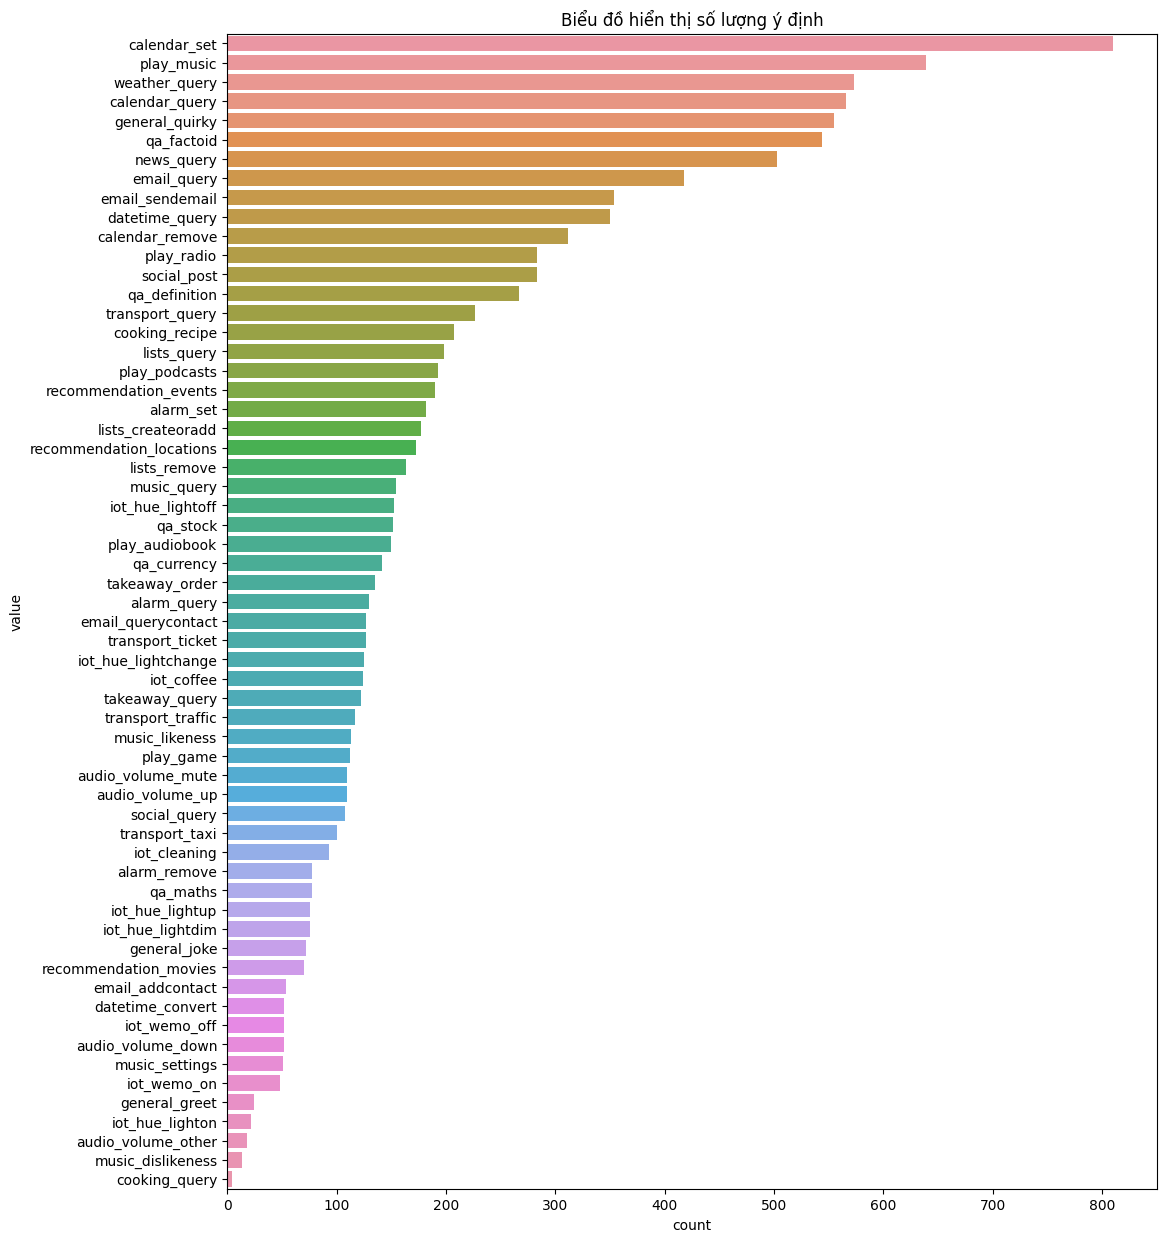

In [41]:
plt.figure(figsize=(12,15))
ax = sns.barplot(y='value', x='count', data=df_)
ax.set_title('Biểu đồ hiển thị số lượng ý định')
plt.show()

# Tiền xử lý dữ liệu

In [42]:
import py_vncorenlp
py_vncorenlp.download_model() 
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"])

In [43]:
import re
import string
import emoji

def preprocessing_text(text, word_segment=True):
  # Biến đổi về chữ thường
  text = text.lower()
  # Loại bỏ biểu tượng
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  # Loại bỏ các dấu câu
  translator = str.maketrans('', '', string.punctuation)
  text = text.translate(translator)
  # Phân đoạn từ bằng py_vncorenlp
  if word_segment == False:
    return text
  text = rdrsegmenter.word_segment(text)

  return " ".join(text).strip()
test_text = preprocessing_text("chưa áp dụng công nghệ thông tin và các thiết bị hỗ trợ cho việc giảng dạy .")
test_text

'chưa áp_dụng công_nghệ_thông_tin và các thiết_bị hỗ_trợ cho việc giảng_dạy'

In [44]:
model_checkpoint = 'vinai/phobert-base'

In [45]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [46]:
tokenizer(test_text)

{'input_ids': [0, 102, 731, 3719, 6, 9, 627, 291, 13, 49, 3108, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [47]:
def tokenize_fn(batch):
  batch['utt'] = list(map(lambda x: preprocessing_text(x), batch['utt']))
  tokenized_inputs = tokenizer(batch['utt'], truncation=True)
  tokenized_inputs['labels'] = batch['intent']
  return tokenized_inputs

In [48]:
tokenized_ds = raw_ds.map(tokenize_fn, batched=True, remove_columns=raw_ds['train'].column_names)

Map:   0%|          | 0/11514 [00:00<?, ? examples/s]

Map:   0%|          | 0/2033 [00:00<?, ? examples/s]

Map:   0%|          | 0/2974 [00:00<?, ? examples/s]

In [49]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2974
    })
})

In [56]:
from transformers import AutoModelForSequenceClassification

id2label = {k:v for k,v in enumerate(name_intents)}
label2id = {v:k for k,v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=len(name_intents), id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

In [57]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [52]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                       Param #
RobertaForSequenceClassification                             --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   49,152,768
│    │    └─Embedding: 3-2                                   198,144
│    │    └─Embedding: 3-3                                   768
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
├─RobertaClassificationHead: 1-2                             --
│    └─Linear: 2-3                                           590,592
│    └─Dropout: 2-4                                          --
│    └─Linear: 2-5                                           46,140
T

In [60]:
from transformers import TrainingArguments

save_checkpoint = 'intent_detection_model'
training_args = TrainingArguments(
    output_dir=save_checkpoint,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8

)

In [61]:
#Định nghĩa hàm đánh giá các chỉ số
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = accuracy_score(labels, predictions)
  f1 = f1_score(labels, predictions, average='weighted')
  return {'accuracy': acc, 'f1': f1}

In [62]:
from transformers import Trainer 
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [63]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.497300,1.052869,0.755042,0.732409
2,0.980400,0.709152,0.820954,0.820970
3,0.450300,0.703945,0.839154,0.834424
4,0.349700,0.739127,0.853910,0.847058
5,0.214700,0.763275,0.848008,0.846154
6,0.154700,0.845972,0.846040,0.845276
7,0.103300,0.849053,0.850467,0.848559
8,0.074700,0.942500,0.846532,0.846322
9,0.061200,0.933402,0.853910,0.851692
10,0.035700,0.942206,0.854894,0.853335


TrainOutput(global_step=10800, training_loss=0.2873668126706724, metrics={'train_runtime': 1393.08, 'train_samples_per_second': 123.977, 'train_steps_per_second': 7.753, 'total_flos': 2333540945916144.0, 'train_loss': 0.2873668126706724, 'epoch': 15.0})

#Lưu và sử dụng model

In [64]:
!ls intent_detection_model

checkpoint-10080  checkpoint-2880  checkpoint-5760  checkpoint-7920
checkpoint-10800  checkpoint-3600  checkpoint-6480  checkpoint-8640
checkpoint-1440   checkpoint-4320  checkpoint-720   checkpoint-9360
checkpoint-2160   checkpoint-5040  checkpoint-7200  runs


In [65]:
from transformers import pipeline

In [67]:
saved_model = pipeline('text-classification',
                       model='intent_detection_model/checkpoint-10800')

In [68]:
val_pred = saved_model(list(map(lambda x: preprocessing_text(x), raw_ds['validation']['utt'])))

In [69]:
val_pred = [label2id[d['label']] for d in val_pred]

In [70]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accuracy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results
calculate_result(raw_ds['validation']['intent'], val_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8588293162813576,
 'precision': 0.860416234542709,
 'recall': 0.8588293162813576,
 'f1-score': 0.858212426789187}

In [71]:
from sklearn.metrics import accuracy_score, classification_report

# Tạo dict classification report
classification_report_dict = classification_report(raw_ds['validation']['intent'], val_pred, output_dict=True)
classification_report_dict

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '1': {'precision': 0.8861788617886179,
  'recall': 0.8861788617886179,
  'f1-score': 0.8861788617886179,
  'support': 123},
 '2': {'precision': 0.42857142857142855,
  'recall': 0.6,
  'f1-score': 0.5,
  'support': 5},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2},
 '4': {'precision': 0.8897058823529411,
  'recall': 0.9236641221374046,
  'f1-score': 0.9063670411985019,
  'support': 131},
 '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8},
 '6': {'precision': 0.7,
  'recall': 0.7777777777777778,
  'f1-score': 0.7368421052631577,
  'support': 18},
 '7': {'precision': 0.8571428571428571,
  'recall': 0.8,
  'f1-score': 0.8275862068965518,
  'support': 15},
 '8': {'precision': 0.6,
  'recall': 0.8571428571428571,
  'f1-score': 0.7058823529411764,
  'support': 7},
 '9': {'precision': 0.9166666666666666,
  'recall': 0.9166666666666666,
  'f1-score': 0.9166666666666666,
  'suppo

In [72]:

# Chỉ lấy f1 score và tạo dataframe
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == 'accuracy': break
  else: class_f1_scores[name_intents[int(k)]] = v['f1-score']
import pandas as pd
f1_scores = pd.DataFrame({'intent': list(class_f1_scores.keys()),
                         'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
f1_scores
     

,intent,f1-score
31,general_joke,1.000000
5,audio_volume_down,1.000000
47,transport_traffic,1.000000
11,iot_coffee,1.000000
21,alarm_remove,0.962963
24,transport_taxi,0.962963
10,audio_volume_up,0.960000
52,transport_ticket,0.960000
29,qa_currency,0.952381
54,iot_cleaning,0.947368


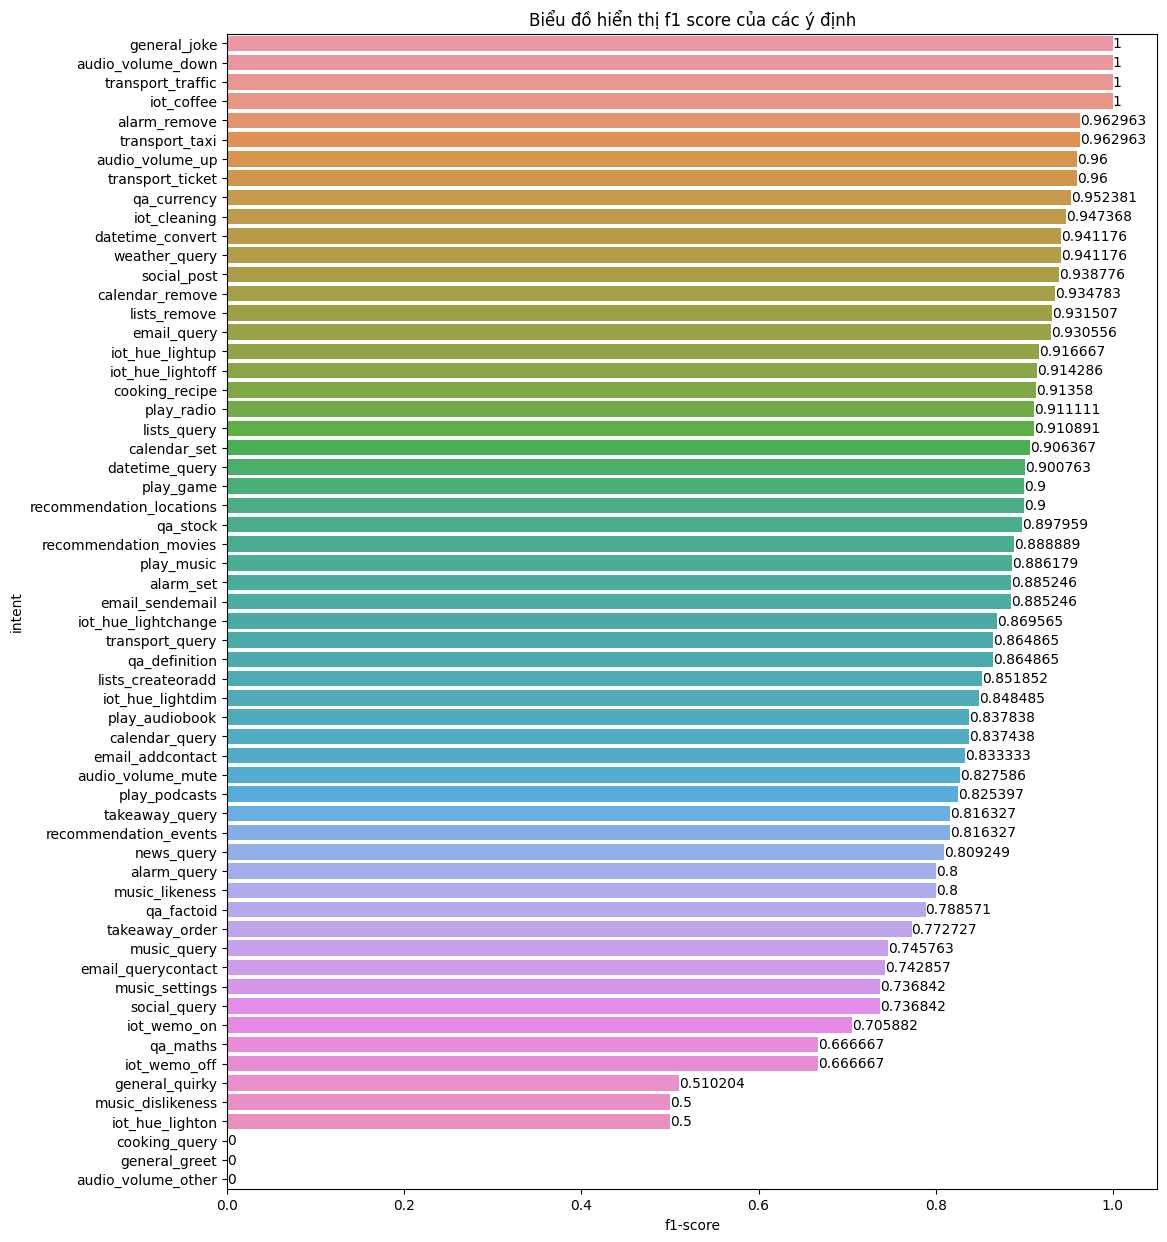

In [76]:
plt.figure(figsize=(12,15))
ax = sns.barplot(y='intent', x='f1-score', data=f1_scores)
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)
ax.set_title('Biểu đồ hiển thị f1 score của các ý định')
plt.show()

- Vì dữ liệu bị lệch khá nhiều nên các intent như cooking_query, general_greet, audio_volume_orther có f1-score =0.
- Giải pháp là tăng cường thêm dữ liệu cho các lớp có f1 thấp